In [0]:
# Download images and store them into tmp directory
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2019-08-17 13:26:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   147MB/s    in 1.0s    

2019-08-17 13:26:24 (147 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [0]:
# Unzip file
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [0]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [0]:
# Let's see what the filenames look like in the horses and humans training directories 
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)
print(train_horse_names[:10])
print(train_human_names[:10])

['horse23-1.png', 'horse23-2.png', 'horse09-5.png', 'horse33-6.png', 'horse38-9.png', 'horse02-8.png', 'horse07-2.png', 'horse28-3.png', 'horse43-8.png', 'horse24-8.png']
['human10-22.png', 'human06-06.png', 'human05-25.png', 'human08-07.png', 'human04-01.png', 'human10-15.png', 'human11-03.png', 'human09-05.png', 'human03-23.png', 'human08-25.png']


In [0]:
# Total number of images in each directory
print('Total training horse images:', len(train_horse_names))
print('Total training human images:', len(train_human_names))

Total training horse images: 500
Total training human images: 527


In [0]:
# Now let's take at a few pictures to get better sense of what they look like
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# We'll output images in a 4x4 configuration
n_rows, n_cols = 4, 4
# Index for iterating over images
pic_index = 0

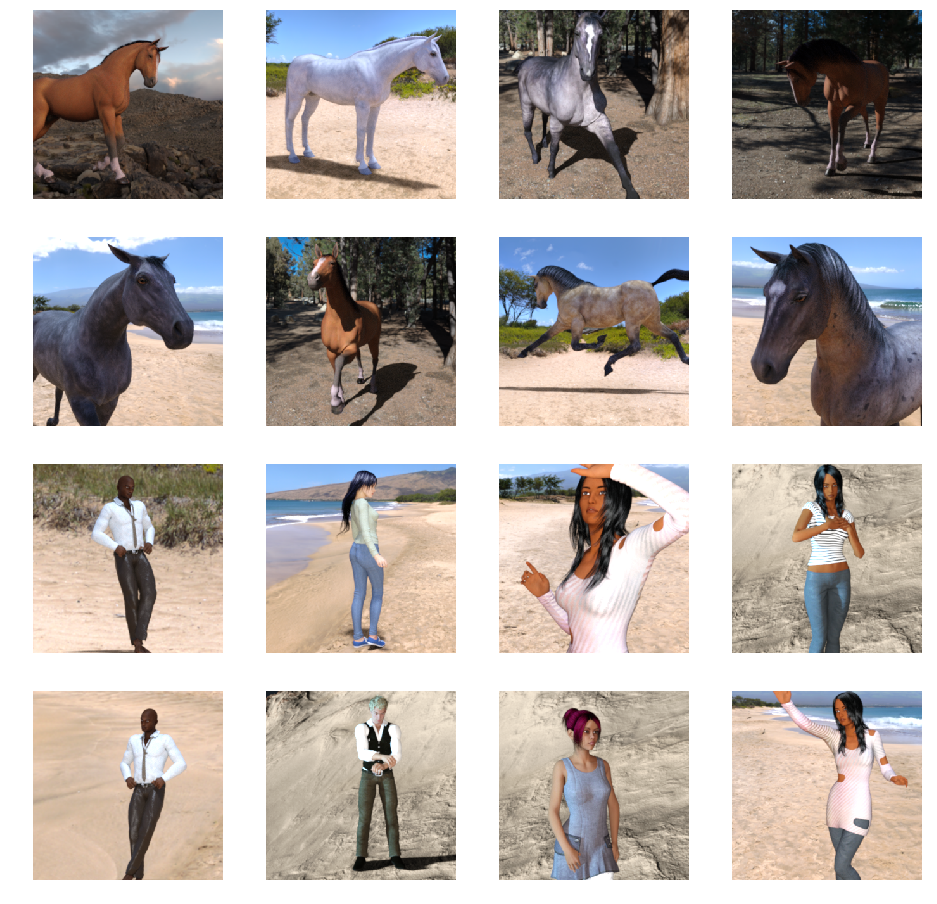

In [0]:
# Now we're going to display 8 images of horses an 8 for humans

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(n_rows * 4, n_cols * 4, )

pic_index += 8
next_horses = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[pic_index-8:pic_index]]
next_humans = [os.path.join(train_human_dir, fname) for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horses + next_humans):
  sp = plt.subplot(n_rows, n_cols, i + 1)
  sp.axis('Off')
  
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [0]:
# Building a small model

import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

W0817 13:58:25.459019 140380151543680 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [0]:
# Compile model: For that, we need an optimizer, a loss function, and metrics

from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])

W0817 14:01:05.257123 140380151543680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Data preprocessing with ImageDataGenerator of Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(1./255) # We rescale all images between 0 and 1

# Flow training images in batches of 128 using train_datagen
train_generator = train_datagen.flow_from_directory(
                    '/tmp/horse-or-human', # Directory containing images
                    target_size=(300, 300), # All images will be resized to 300x300
                    batch_size=128, # Images will be loaded in batches of 128
                    class_mode='binary')

Found 1027 images belonging to 2 classes.


In [0]:
# Training the model
history = model.fit_generator(train_generator, steps_per_epoch=8, epochs=15, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


8/8 [==============================] - 81s 10s/step - loss: 118.7660 - acc: 0.5350
Epoch 2/15
8/8 [==============================] - 78s 10s/step - loss: 0.9373 - acc: 0.6674
Epoch 3/15
8/8 [==============================] - 78s 10s/step - loss: 1.1052 - acc: 0.5840
Epoch 4/15
8/8 [==============================] - 87s 11s/step - loss: 0.3656 - acc: 0.8311
Epoch 5/15
8/8 [==============================] - 78s 10s/step - loss: 3.1267 - acc: 0.6552
Epoch 6/15
8/8 [==============================] - 78s 10s/step - loss: 0.7703 - acc: 0.6396
Epoch 7/15
8/8 [==============================] - 68s 8s/step - loss: 0.4935 - acc: 0.7610
Epoch 8/15
8/8 [==============================] - 88s 11s/step - loss: 0.2149 - acc: 0.9102
Epoch 9/15
8/8 [==============================] - 77s 10s/step - loss: 1.7760 - acc: 0.6518
Epoch 10/15
8/8 [==============================] - 72s 9s/step - loss: 0.3714 - acc: 0.8420
Epoch 11/15
8/8 [==============================] - 77s 10s/step - loss: 0.3538 - acc: 0.89

In [0]:
# Runining th model
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving a.jpg to a.jpg
[0.]
a.jpg is a horse


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


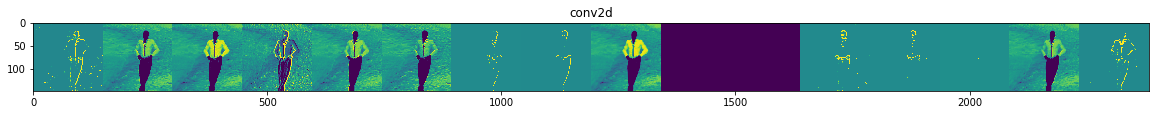

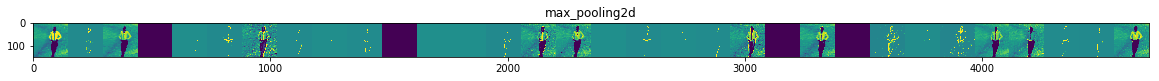

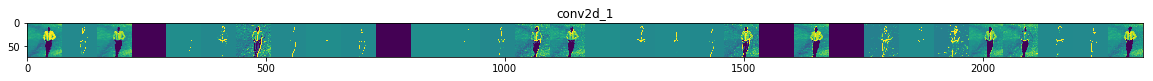

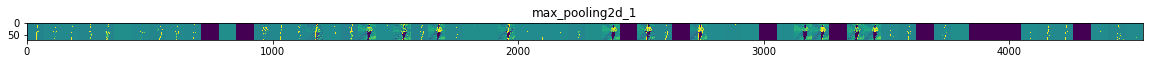

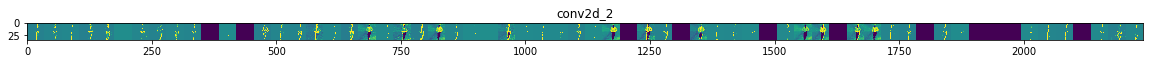

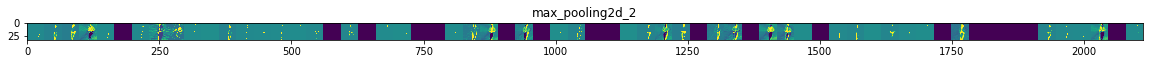

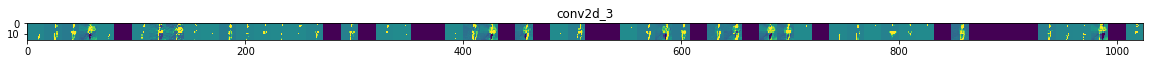

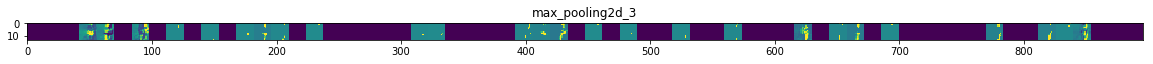

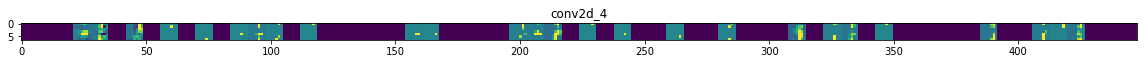

In [0]:
# Visualizing intermediate representations
import random
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:
# Terminate the kernel and free memory resources
import signal
os.kill(os.getpid(), signal.SIGKILL)